# Analyzing SOFC data (parts 2 and 3)

## 2) Leave-one-out cross-validation
In the previous notebook, I attempted to analyze the ~100 data points by splitting the data set into 60/20/20 ratios of training, cross-validation, and test data. This led to a model that overfit the data because there were too few data points to make a generalizable model.

Here I will use the leave-one-out cross validation technique, which generates n test sets with n-1 training examples in each.

In [21]:
from sofc_func import *
%matplotlib inline

In [22]:
# Import using pandas
df = pd.read_csv("data.csv")

# Clean out rows where there is no parent A or parent B

data = df[pd.notnull(df['A_par']) & pd.notnull(df['B_par']) & pd.notnull(df['d_star']) & pd.notnull(df['k_star']) 
             & pd.notnull(df['e affinity(B)']) & pd.notnull(df['d-electron count (B)'])]

pd.options.mode.chained_assignment = None

data = features(df)

data['dk_star'] = pd.Series(dk_star(data,1000), index=df.index)

full_data = data[pd.notnull(data['avg_EA_B']) & pd.notnull(data['avg_d_count_B']) & pd.notnull(data['dk_star'])]

Y = np.array(full_data[ ['dk_star'] ])
X = np.array(full_data[ ['avg_EA_B', 'avg_d_count_B'] ])

###Leave-one-out cross-validation:
Because the scores are subject to noise from random sampling of the data sets, I will loop through the exercise 100 times and average the results.

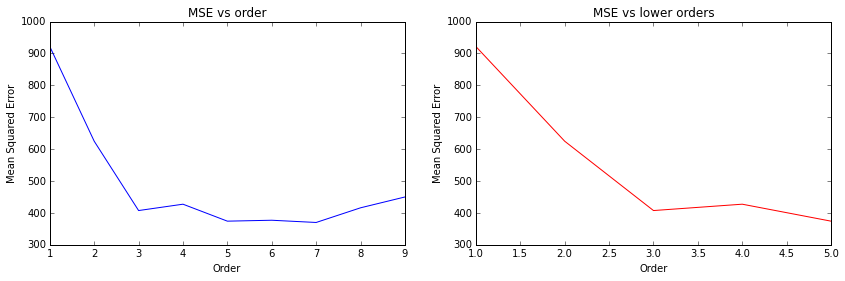

Polynomial order optimization executed in: 90.047562s


In [23]:
optimize_order(100, len(Y), 1, X,Y, False)

### The model is optimized with a fifth order polynomial .
I will now create an averaged model using these parameters and 100 iterations.

In [25]:
get_scores(100, 1,3,len(Y),X,Y, False)

Average MSE of this model: 407.417344362
Standard deviation of MSE: 1.13686837722e-13


###EN and d-electron count explain about 3/4 of the variation in the data. Where does the rest of it come from?
In the previous notebook I started to explore categorical variables, but never got to their analysis. I will not revisit the material family, sample type, and measurement type categories. Note that I expect measurement type to explain no real variance because measurements should not depend on the method of collection.

## 3) Categorical variables:

Remember how the three families of materials looked clustered in the previous notebook? The sets of Ruddlesden-Popper and double perovskite materials each had very small ranges for electronegativity of the B-site cation, but this model isn't taking material family into consideration.

Ruddlesden-Popper phases have structures that are more conducive to a higher D\*k\* and double perovskites order into structures that also exhibit large D\*k\*. Surely this categorization should explain some of the variability.

Another category that may have an effect is sample type. Thin film and single crystals are much cleaner than ceramic samples, which often translates to higher D\*k\* because they aren't hindered by problems in grain orientation.

###I will dummy code again

In [44]:
f = pd.get_dummies(full_data['family'], prefix='family')
m = pd.get_dummies(full_data['measurement_type'], prefix='m')
s = pd.get_dummies(full_data['sample_type'], prefix='s')

full_data = full_data.drop('family', axis=1)
full_data = full_data.drop('measurement_type', axis=1)
full_data = full_data.drop('sample_type', axis=1)

full_data = pd.concat([full_data, f], axis=1)
full_data = pd.concat([full_data, m], axis=1)
full_data = pd.concat([full_data, s], axis=1)

KeyError: 'family'

###Material family:

In [27]:
X = np.array(full_data[ ['avg_d_count_B', 'avg_EA_B', 'family_Perovskite', 
          'family_Ruddlesden-Popper', 'family_Double Perovskite']])
Y = np.array(full_data[ ['dk_star'] ])

#optimize_k(200, len(X), X,Y, False)

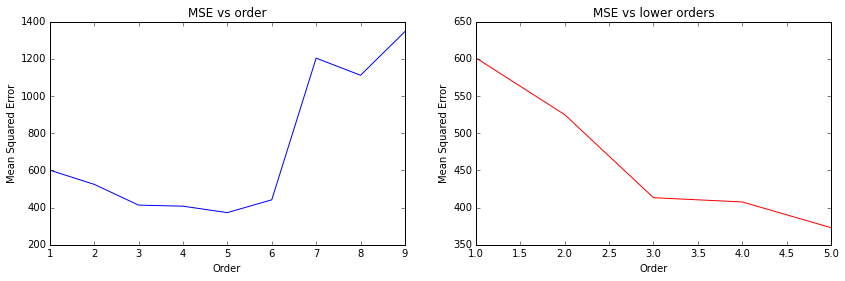

Polynomial order optimization executed in: 773.753831s


In [29]:
optimize_order(50, len(X), 1, X, Y, False)

Same order as before. I'll look at the score for order=5:

In [31]:
get_scores(50,1,5,len(X),X,Y, False)

Average MSE of this model: 373.00408731
Standard deviation of MSE: 5.68434188608e-14


###Adding material family categories reduces MSE by 8.3%

###Sample type:

In [32]:
X = np.array(full_data[ ['avg_d_count_B', 'avg_EA_B', 's_Ceramic', 
          's_Single Crystal', 's_Thin Film']])
Y = np.array(full_data[ ['dk_star'] ])

#optimize_k(200, len(X), X,Y, False)

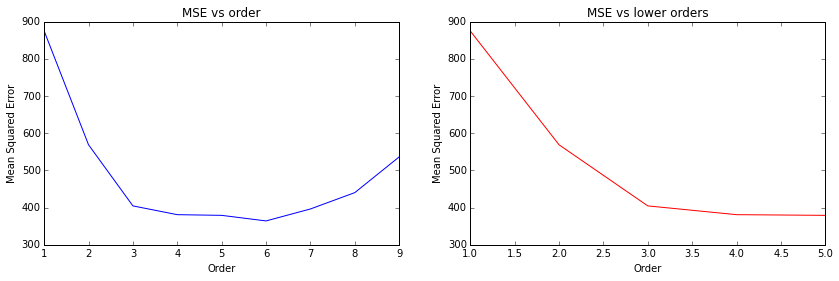

Polynomial order optimization executed in: 883.498063s


In [35]:
optimize_order(50, len(X), 1, X, Y, False)

In [37]:
get_scores(50,1,5,len(X),X,Y, False)

Average MSE of this model: 379.149010655
Standard deviation of MSE: 5.68434188608e-14


###Adding sample type reduces MSE by 6.9%

###Material family AND sample type:

In [41]:
X = np.array(full_data[ ['avg_d_count_B', 'avg_EA_B', 's_Ceramic', 
          's_Single Crystal', 's_Thin Film','avg_d_count_B', 'avg_EA_B', 'family_Perovskite', 
          'family_Ruddlesden-Popper', 'family_Double Perovskite']])
Y = np.array(full_data[ ['dk_star'] ])

In [43]:
get_scores(50,1,5,len(X),X,Y, False)

Average MSE of this model: 363.328842008
Standard deviation of MSE: 5.68434188608e-14


###Adding material family AND sample type reduces MSE by 14.3%

###Measurement type:
(I expect this to have no effect)

In [38]:
X = np.array(full_data[ ['avg_d_count_B', 'avg_EA_B', 'm_IEDP/SIMS','m_ECR', 'm_EBSP']])
Y = np.array(full_data[ ['dk_star'] ])

#optimize_k(200, len(X), X,Y, False)

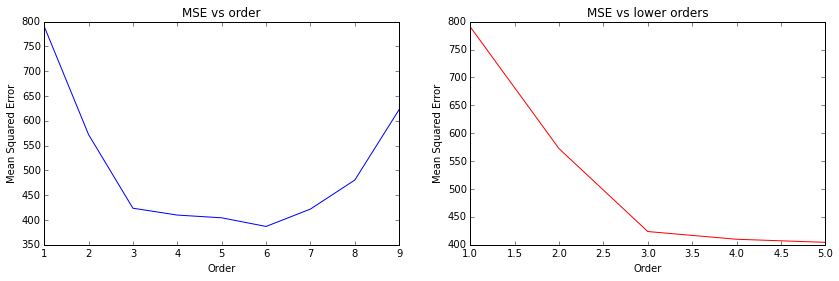

Polynomial order optimization executed in: 813.892191s


In [39]:
optimize_order(50, len(X), 1, X, Y, False)

In [40]:
get_scores(100,1,5,len(X),X,Y, False)

Average MSE of this model: 404.424170647
Standard deviation of MSE: 5.68434188608e-14


###Adding measurement type reduces MSE by 0.7%

#Conclusion:
The contribution to variance by the categorical variables themselves is relatively small. Material family has the largest contribution, with an 8.3% reduction in mean squared error of the 5th order polynomial. Sample type reduces MSE by 6.9%. Measurement type only reduces MSE by 0.7%. I expected measurement type to have no effect - it was a control here.

When material family and sample type are both added to the model, MSE is reduced by 14.3%. This is enough of a difference to warrant adding them to the final model.

In the next notebook, I will analyze the rest of the quantitative variables to see if they have any significant impact.